In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

import Models.OWID as owid
import Models.SIRD as sird
import Models.GradientDescent as gd

import scipy.optimize as opt

#parameters are [A(0), I(0), gamma0, gamma1, nu, beta0, beta1, beta2, u(t) vars]
#consts are [dayNum, I[0], maxI, len(u(t))]

#A' = (b0 / (1 + (b1 * I)**(b2 * u(t)) ) )*A - gamma0*A
#I' = gamma1*A - nu*I


def startFunc(consts):
    
    #return ukVars
    params = np.zeros(8)
        
    params[0] = .0001 + consts[1] #A(0), between 0 and 10 percent of the population
    params[1] = consts[1] #10e-10 + random.random()*.01 #I(0), between 0 and .1 percent of the population, avoid 0
    
    params[2] = .1 + random.random()*.4 #gamma0, asympt->recovs + infected - floor asympt infect rate
    params[3] = .001 + random.random()*.1 #gamma1, asympt->infected
    
    params[4] = .001 + random.random()*.1 #nu, infected -> recov or dead

    params[5] = .3 + random.random()*1.5 #beta0, ceiling infectRate - floor infect rate
    params[6] = 3 + 10*random.random() #beta2, scaler on feedback
    params[7] = .5 + random.random()*2 #beta3, exponential [.5, 5.5]
    
    #beta1 = (b0/gamma0 - 1)**(1/u(t)*b2) / maxI
    #params[6] = ((params[5]/params[2])-1)**(1/(params[7])) / consts[2]
    
    
    return params
    
def simFunc(params, consts, giveA=False): #option to return A and I

    dayNum = consts[0]
    
    A = np.zeros((dayNum))
    I = np.zeros((dayNum))
    
    A[0] = params[0]
    I[0] = params[1]
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    
    beta = params[5:8]

    #print(params)
    
    #iterate the arrays using the definition K' and I'
    for t in range(len(I)-1): #define I and K on range [1, length)
        diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
        diffI = gamma1*A[t] - nu*I[t]
        
        A[t+1] = diffA + A[t]
        I[t+1] = diffI + I[t]

    if(giveA):
        return A,I
        
    return I #I is the data generated

def constrainFunc(parameters, consts):
    
    params = np.copy(parameters)

    #fill the constraints
    paramConstraints = np.zeros((len(params),2)) #min, max for each one
    
    paramConstraints[0] = [.0000000001, .5] #A(0)
    paramConstraints[1] = [ 0.000000001, .25] #I(0)

    paramConstraints[2] = [0.00001, parameters[5]] #gamma0, has to be less than ceiling infection rate
    paramConstraints[3] = [0.00001, .9] #gamma1
    
    paramConstraints[4] = [0.00001, .9] #nu

    paramConstraints[5] = [.1, 100] #beta0, beta ceiling
    paramConstraints[6] = [.1, 100000] #beta1, feedback scaling
    paramConstraints[7] = [.25, 10] #beta2
    
    for i in range(len(params)): #exercise each constraint
        params[i] = min( max(paramConstraints[i,0], params[i]) , paramConstraints[i,1])
    
    return params

def graphParams(params, consts, graphA=False):
    A, I = simFunc(params, consts, giveA=True)
    
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphA):
        ax.plot(A, color="orange", linestyle="dashed", alpha=.7)
    ax.plot(I, color="red")
    return fig, ax




#x is the starting params, args = (consts, y)
def errFunc(x, consts, normalWeight, slopeWeight, wDecay, skip, y):
    
    def simFunction(params, consts, giveA=False): #option to return A and I

        dayNum = consts[0]

        A = np.zeros((dayNum))
        I = np.zeros((dayNum))

        A[0] = params[0]
        I[0] = params[1]

        gamma0 = params[2]
        gamma1 = params[3]
        nu = params[4]

        beta = params[5:8]

        #print(params)

        #iterate the arrays using the definition K' and I'
        for t in range(len(I)-1): #define I and K on range [1, length)
            diffA = (beta[0]/ (1 + (beta[1]*I[t])**(beta[2]) ) )*A[t] - gamma0*A[t]
            diffI = gamma1*A[t] - nu*I[t]

            A[t+1] = diffA + A[t]
            I[t+1] = diffI + I[t]

        if(giveA):
            return A,I

        return I #I is the data generated

    x = simFunction(x, consts)
    
    error = 0
    if(normalWeight!=0):
        for t in range(skip,len(y)):
            error = error + ((y[t] - x[t])**2)*wDecay**(len(y)-t+1) #squared error
        error = error / len(y) # / T, average error
    
    
    slopeError = 0
    if(slopeWeight!=0):
        dy = np.diff(y)
        dx = np.diff(x)
        for t in range(skip,len(dy)):
            slopeError = slopeError +  ((dy[t] - dx[t])**2)*wDecay**(len(dy)-t+1) #squared error
        slopeError = slopeError / len(dy) # / T, average error

    return error*normalWeight + slopeError*slopeWeight



def getParams(I, consts, normalWeight=1, slopeWeight=0, wDecay=1, skip=0, randomIterCount=100, method="SLSQP"):
    bestParams = startFunc(consts)
    bestError = 10e10 #arbitrary large value
    
    for i in range(randomIterCount):
        
        newParams = startFunc(consts)
        newParams = opt.minimize(errFunc, newParams, (consts, normalWeight, slopeWeight, wDecay, skip, I), method=method)['x']
        newError = errFunc(newParams, consts, normalWeight, slopeWeight, wDecay, skip, I)
    
        if(newError < bestError):
            bestError = newError
            bestParams = newParams
            print(i, "New best error: ", bestError)
            
    return bestParams

def getStablePoint(params, consts):
    #I stable point = (b0/gamm0 - 1)^(1/b2) / b1
    #A stable point = nu/gamma1 * (b0/gamm0 - 1)^(1/b2) / b1
    
    gamma0 = params[2]
    gamma1 = params[3]
    nu = params[4]
    beta = params[5:]
    
    return (beta[0]/gamma0 - 1)**(1/beta[2]) / beta[1]

In [2]:
randomIterCount = 100
quickRunIters = 25 #how many interations on the first convergance
lastRunIters = 500
beginEta = .01 #large learnin rate for quick converging
finalEta = .01

slopeWeight = 1

## Italy

0 New best error:  2.693641208684929e-05


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in double_scalars


4 New best error:  1.9576129828349626e-05


(0.0, 0.030195573779575175)

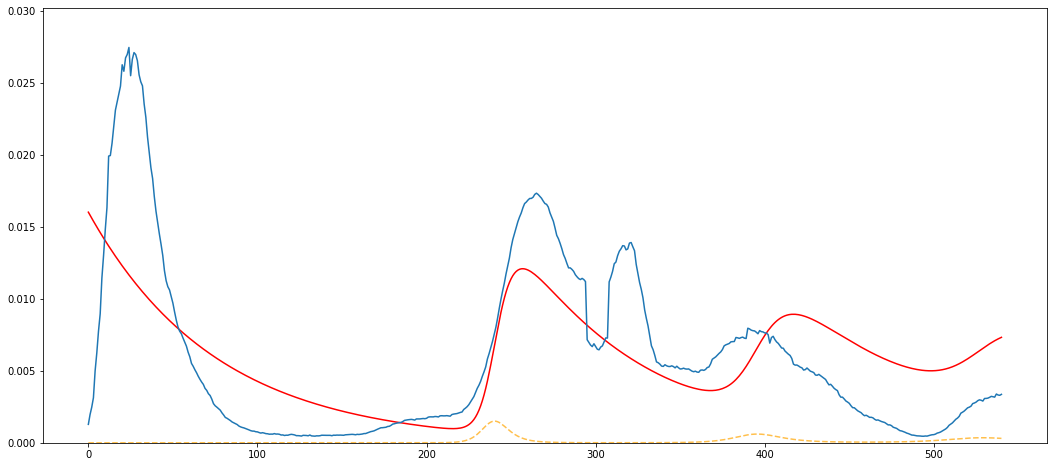

In [4]:
dates, I, R, D, V = owid.LoadCountryNormal("Italy")
consts = [len(I), I[0], max(I), 0]

italyParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(italyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## US

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  7.556550717019354e-06
13 New best error:  7.347536407899265e-06
22 New best error:  6.932009197595585e-06
24 New best error:  6.488395368960738e-06


(0.0, 0.018441267693175955)

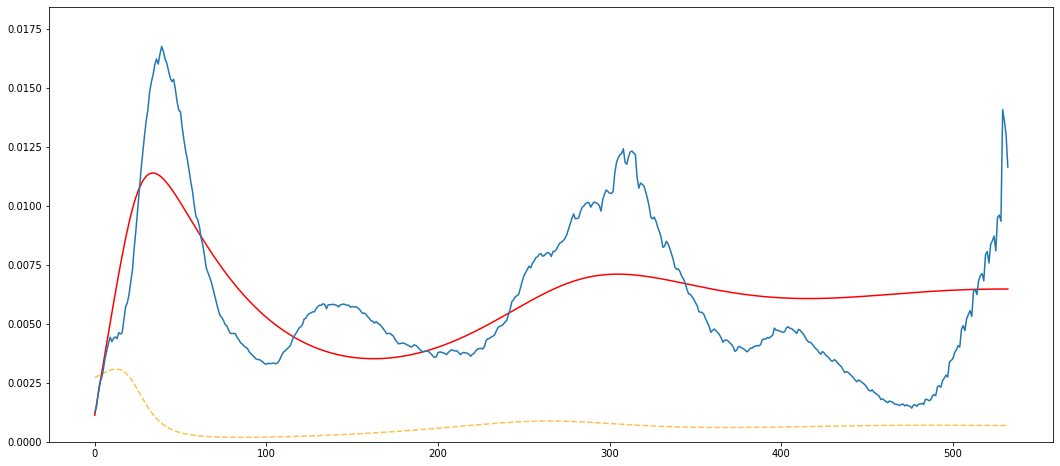

In [5]:
dates, I, R, D, V = owid.LoadCountryNormal("United States")
consts = [len(I), I[0], max(I), 0]

usParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(usParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## UK

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  3.38402040412487e-05
1 New best error:  2.0610218718874295e-05
8 New best error:  2.0076856821378712e-05


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in double_scalars
C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in double_scalars


15 New best error:  1.7380038823398675e-05
16 New best error:  1.2715069935326233e-05


(0.0, 0.04658249629830908)

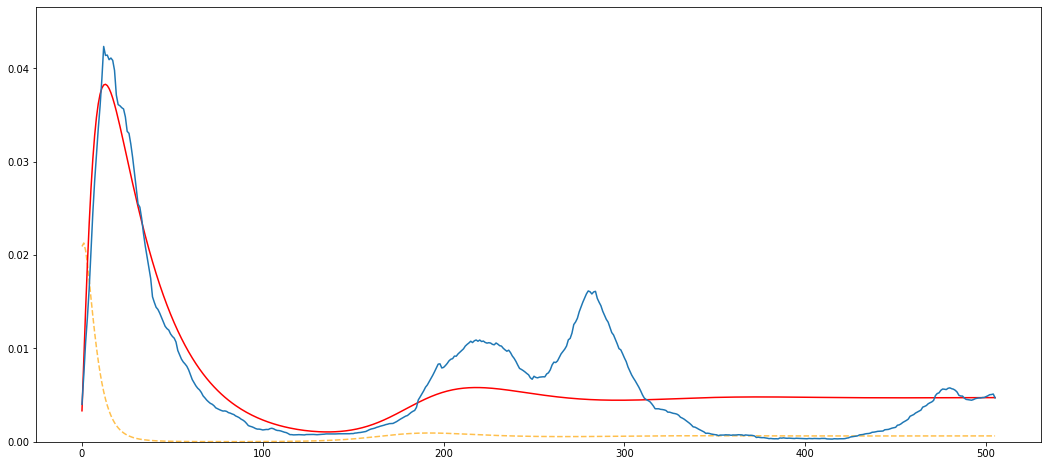

In [6]:
dates, I, R, D, V = owid.LoadCountryNormal("United Kingdom")
consts = [len(I), I[0], max(I), 0]

ukParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(ukParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Canada

0 New best error:  9.813094258576385e-06


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


7 New best error:  8.829046348085802e-06


(0.0, 0.02405621083757516)

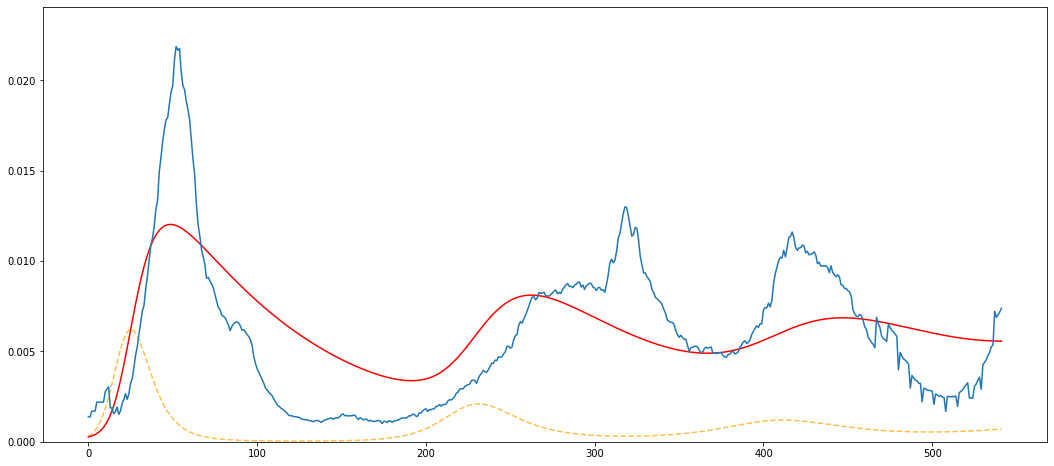

In [7]:
dates, I, R, D, V = owid.LoadCountryNormal("Canada")
consts = [len(I), I[0], max(I), 0]

canadaParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(canadaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Mexico

0 New best error:  2.9808001964818637e-06


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


2 New best error:  1.205033898831214e-06
4 New best error:  1.200293254516827e-06
11 New best error:  1.1825251644070676e-06


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in double_scalars
C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:134: RuntimeWarning: overflow encountered in double_scalars
C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in double_scalars


(0.0, 0.010837001598060553)

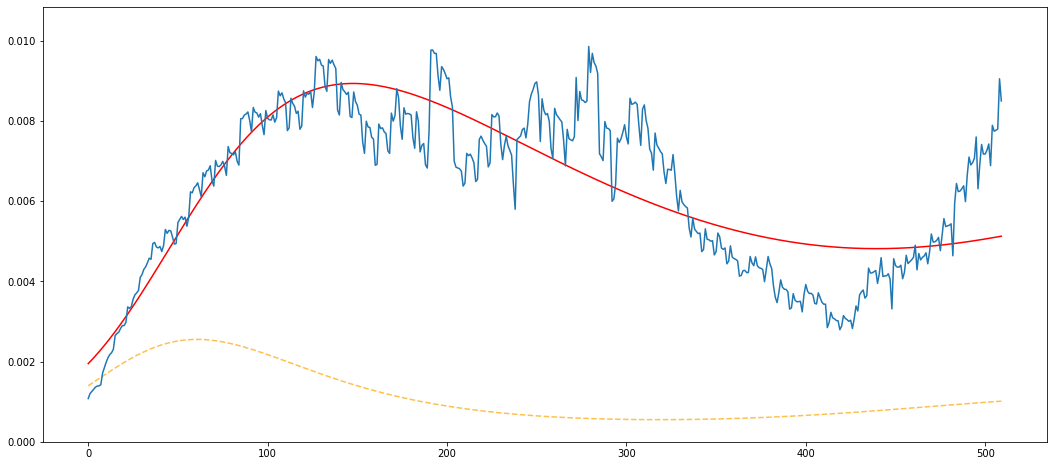

In [8]:
dates, I, R, D, V = owid.LoadCountryNormal("Mexico")
consts = [len(I), I[0], max(I), 0]

mexicoParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(mexicoParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Israel

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  1.950896253270142e-05
1 New best error:  1.9099428081385764e-05
4 New best error:  1.760017071481309e-05
6 New best error:  1.5926105476427874e-05


(0.0, 0.020971920205352997)

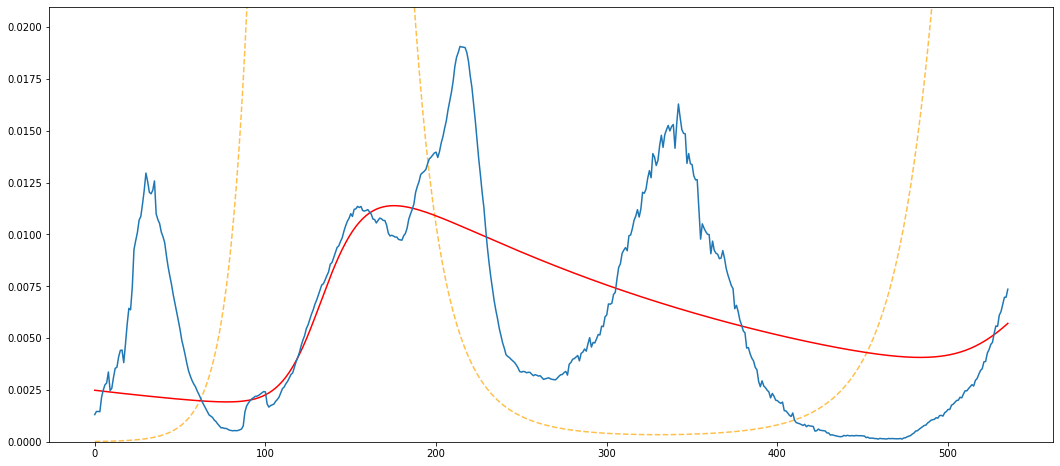

In [9]:
dates, I, R, D, V = owid.LoadCountryNormal("Israel")
consts = [len(I), I[0], max(I), 0]

israelParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(israelParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Russia

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  9.53560758930271e-06
3 New best error:  9.159090637708684e-06
5 New best error:  7.863459712290383e-06


(0.0, 0.015384002666381675)

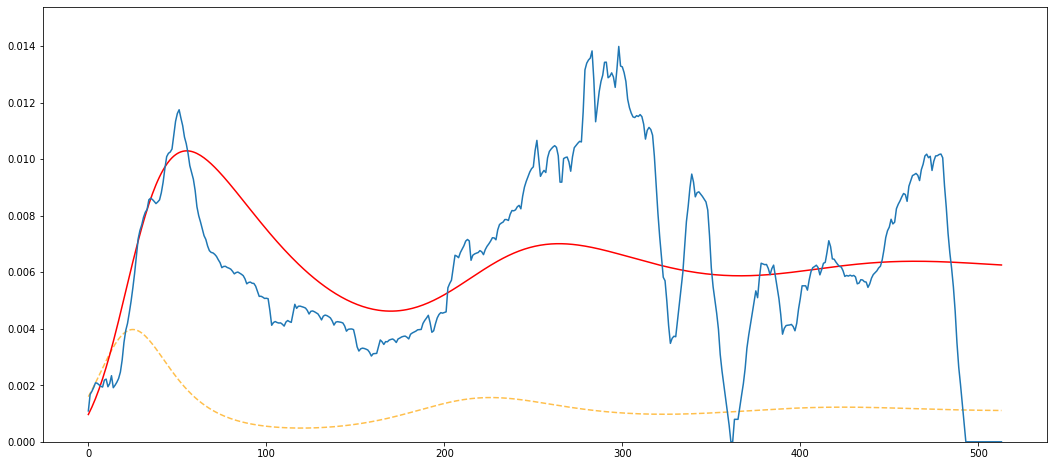

In [10]:
dates, I, R, D, V = owid.LoadCountryNormal("Russia")
consts = [len(I), I[0], max(I), 0]

russiaParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(russiaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## South Africa

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  1.8614801439416173e-05
1 New best error:  1.5592567409956594e-05
3 New best error:  9.466223375699748e-06


C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: overflow encountered in double_scalars
C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in double_scalars


(0.0, 0.01813797736939064)

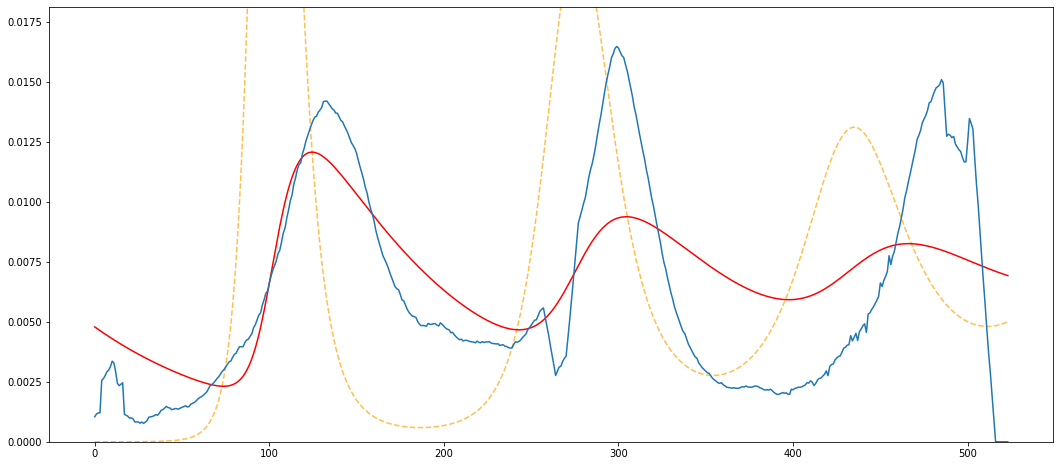

In [11]:
dates, I, R, D, V = owid.LoadCountryNormal("South Africa")
consts = [len(I), I[0], max(I), 0]

southAfricaParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(southAfricaParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Australia

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  0.00020133409186709003
1 New best error:  9.044411366258658e-05


(0.0, 0.06187422274640893)

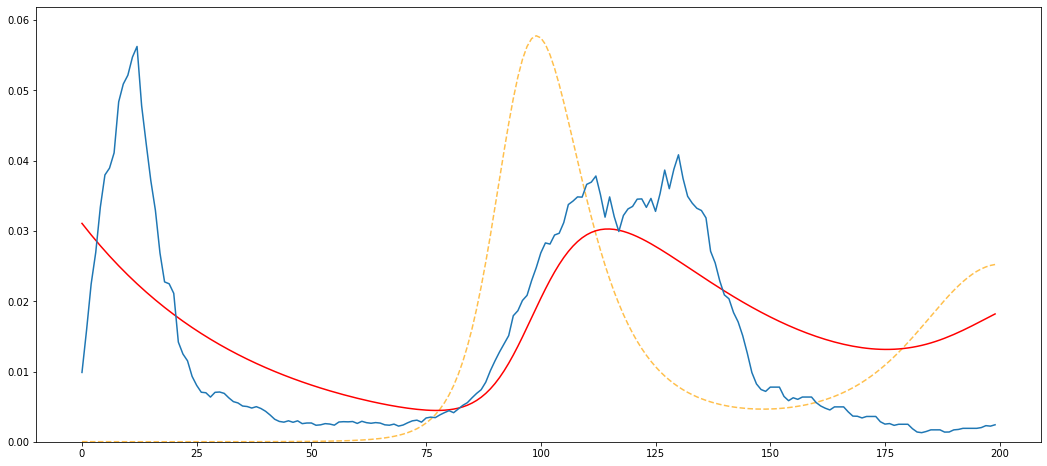

In [12]:
dates, I, R, D, V = owid.LoadCountryNormal("Australia")
dates = dates[0:200]
I = I[0:200]
consts = [len(I), I[0], max(I), 0]

auParams = getParams(I, consts, randomIterCount=25, method = "Nelder-Mead")

fig,ax = graphParams(auParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.1])

## Turkey

C:\Users\daniel\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:131: RuntimeWarning: invalid value encountered in double_scalars


0 New best error:  2.5186185346667467e-05
4 New best error:  1.9327822894834528e-05
5 New best error:  1.9183017169448462e-05
16 New best error:  1.8989019619213254e-05


(0.0, 0.0291976837360973)

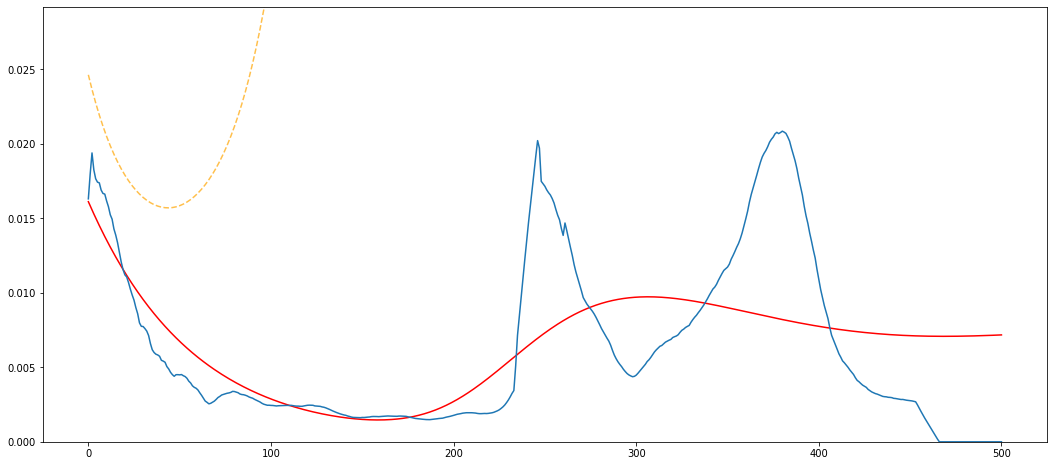

In [13]:
dates, I, R, D, V = owid.LoadCountryNormal("Turkey")

dates = dates[10:]
I = I[10:]
R = R[10:]
D = D[10:]
V = V[10:]

consts = [len(I), I[0], max(I), 0]

turkeyParams = getParams(I, consts, randomIterCount=25, wDecay=(.75**(1/len(I))), method = "Nelder-Mead")

fig,ax = graphParams(turkeyParams, consts, graphA=True)
ax.plot(I)
ax.set_ylim([0, max(I)*1.4])

In [162]:
import csv


outputFile = open('..\\Data\\AIRD fits\\fits.csv', 'w')
writer = csv.writer(outputFile)


row = italyParams.tolist()
row.insert(0, "Italy")
writer.writerow(row)

row = usParams.tolist()
row.insert(0, "United States")
writer.writerow(row)

row = ukParams.tolist()
row.insert(0, "United Kingdom")
writer.writerow(row)

row = canadaParams.tolist()
row.insert(0, "Canada")
writer.writerow(row)

row = mexicoParams.tolist()
row.insert(0, "Mexico")
writer.writerow(row)

row = israelParams.tolist()
row.insert(0, "Israel")
writer.writerow(row)

row = russiaParams.tolist()
row.insert(0, "Russia")
writer.writerow(row)

row = southAfricaParams.tolist()
row.insert(0, "South Africa")
writer.writerow(row)

row = auParams.tolist()
row.insert(0, "Australia")
writer.writerow(row)

row = turkeyParams.tolist()
row.insert(0, "turkey")
writer.writerow(row)

outputFile.close()

normal-death error:  7.499631978033246e-05
mod-death error:  0.00013316714788320924
mod/normal error: 1.7756491021594354


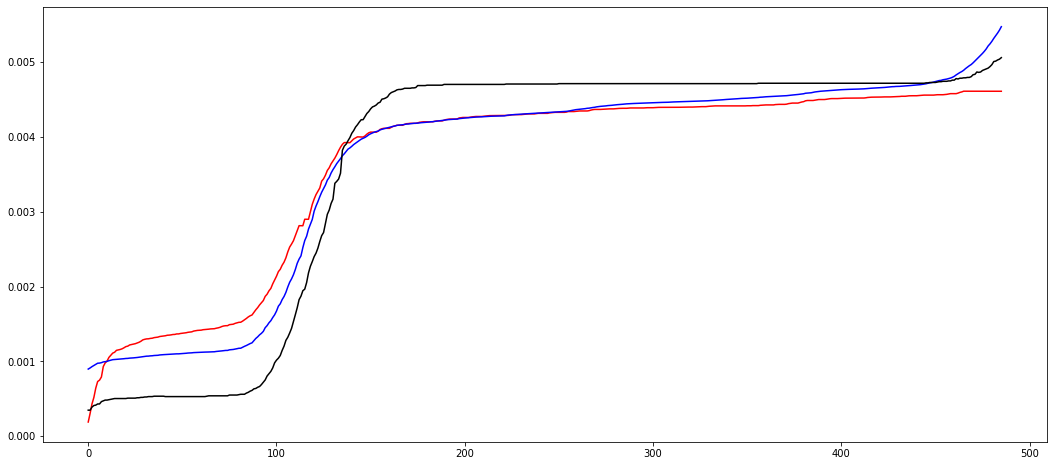

In [92]:
countryName = "Australia"

dates, I, R, D, V = owid.LoadCountryNormal(countryName)

dates2, [actualI, pop] = owid.LoadCountry(countryName, [4, 46])

startDate = np.where(dates2 == dates[0])[0][0]
endDate = np.where(dates2 == dates[-1])[0][0]

dates2 = dates2[startDate:endDate+1]
actualI = actualI[startDate:endDate+1]
pop = pop[0]

actualI = actualI/pop #transform so max pop is 1

shiftAmount = 15
deadShift = D[shiftAmount:]
modIShift = I[0:-shiftAmount] + R[0:-shiftAmount]
actualIShift = actualI[0:-shiftAmount]

fig,ax = plt.subplots(figsize=(18,8))

deathScale = (sum(modIShift)/len(modIShift)) / (sum(deadShift)/len(deadShift))
infectScale = (sum(modIShift)/len(modIShift)) / (sum(actualIShift)/len(actualIShift))

ax.plot(modIShift, color="red")
ax.plot(infectScale*actualIShift, color="blue")
ax.plot(deathScale*deadShift, color="black")

normalError = sum(((infectScale*actualIShift)-(deathScale*deadShift))**2)
modError = sum(((modIShift)-(deathScale*deadShift))**2)
print("normal-death error: ", normalError)
print("mod-death error: ", modError)
print("mod/normal error:", modError/normalError)

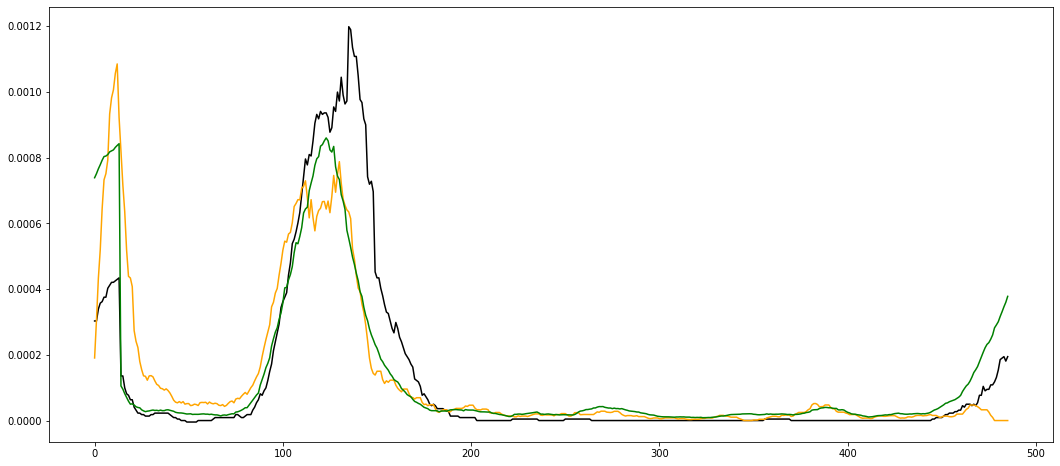

In [93]:
fig, ax = plt.subplots(figsize=(18,8))

recov = np.zeros(len(deadShift)) #R+D
shift = 14
for i in range(len(deadShift) - shift):
        recov[i + shift] = deadShift[i]

reportedI = actualIShift
recov2 = np.zeros(len(deadShift)) #R+D
for i in range(len(reportedI) - shift):
        recov2[i + shift] = reportedI[i]

reportedI = reportedI - recov2
currInfect = deadShift - recov
modIShift = I[0:-shiftAmount]

currInfect = currInfect * (sum(modIShift)/len(modIShift)) / (sum(currInfect)/len(currInfect))
reportedI = reportedI * (sum(modIShift)/len(modIShift)) / (sum(reportedI)/len(reportedI))

ax.plot(currInfect, color="black") #approx from dead
ax.plot(modIShift, color="orange") #approx from tests
ax.plot(reportedI, color="green") #reported